In [1]:
import pandas
import nipy
from nipy.modalities.fmri import hrf

In [2]:
df = pandas.read_csv('data/sim-data_drift-SP-variability-estim-onep.csv', index_col=0)

In [3]:
import numpy as np

In [4]:
df['onset'] = np.arange(10, len(df)*10 + 1, 10)

In [5]:
df = df.iloc[:5]

In [6]:
def get_bold_response(df, method='time_on_task',
                      cue_delay=None,
                      sample_rate=1000):
    
    neural_signal = np.zeros((df.onset.max() + 20) * sample_rate)
    
    hrf = nipy.modalities.fmri.hrf.spm_hrf_compat(np.arange(0, 20, 1./sample_rate))
    
    for ix, row in df.iterrows():
        
        if method == 'time_on_task':
            start_idx = int(row.onset * sample_rate)
            end_idx = int((row.onset + row.rt)*sample_rate)
            value = 1
            
        elif method == 'time_on_task_drift':
            start_idx = int(row.onset * sample_rate)
            end_idx = int((row.onset + row.rt)*sample_rate)
            value = row.drift_t   
            
        elif method == 'error_monitoring':            
            feedback_delay = np.random.choice([.200, .700, 1.200, 1.700])            
            start_idx = int((row.onset + row.rt+feedback_delay)*sample_rate)
            end_idx = int(start_idx + .35 *sample_rate)            
            value =  1.5  - row.accuracy
        
        if cue_delay is None:        
            neural_signal[start_idx:end_idx] = value
        else:            
            offset = np.random.choice(cue_delay) * sample_rate            
            neural_signal[start_idx+offset:end_idx+offset] = value
            
        
    
    bold_signal = np.convolve(hrf, neural_signal)
    
    return neural_signal, bold_signal
    
    

In [7]:
sample_rate = 100

In [32]:
df = pandas.DataFrame({'rt':[2.5/2., 7.5/2., 2.5/2., 7.5/2.],
                       'accuracy':[1, 1, 0, 0], 
                       'onset':np.arange(10, 50, 10)})

In [33]:
df

,accuracy,onset,rt
0,1,10,1.25
1,1,20,3.75
2,0,30,1.25
3,0,40,3.75


In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

In [62]:
import seaborn as sns

In [65]:
sns.set_style('white')

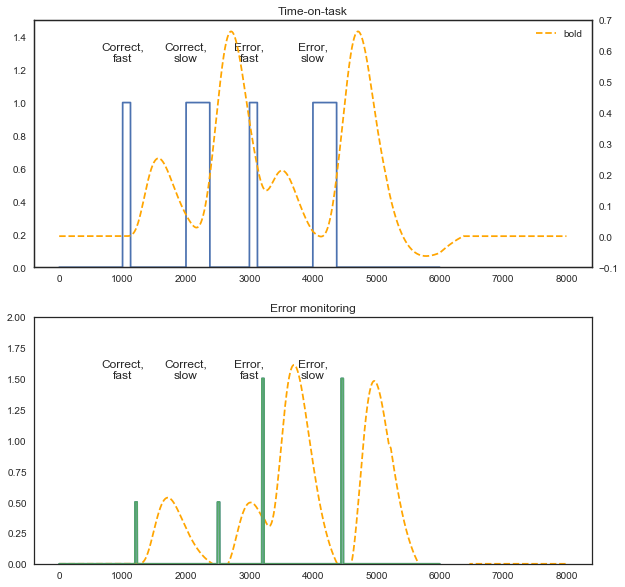

In [76]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))
plt.title('Time-on-task')
plt.sca(axes[0])
plt.title('Time-on-task')

plt.text(1000, 1.25, 'Correct,\nfast', ha='center')
plt.text(2000, 1.25, 'Correct,\nslow', ha='center')

plt.text(3000, 1.25, 'Error,\nfast', ha='center')
plt.text(4000, 1.25, 'Error,\nslow', ha='center')
plt.ylim(0, 1.5)

neural_signal, bold_signal = get_bold_response(df, sample_rate=sample_rate)
plt.plot(neural_signal, label='neural')

ax2 = axes[0].twinx()
plt.plot(bold_signal, label='bold', ls='--', color='orange')
plt.legend()

plt.sca(axes[1])
plt.title('Error monitoring')

plt.text(1000, 1.5, 'Correct,\nfast', ha='center')
plt.text(2000, 1.5, 'Correct,\nslow', ha='center')

plt.text(3000, 1.5, 'Error,\nfast', ha='center')
plt.text(4000, 1.5, 'Error,\nslow', ha='center')
plt.ylim(0, 2.0)

neural_signal, bold_signal = get_bold_response(df, 'error_monitoring', sample_rate=sample_rate)
plt.plot(neural_signal, label='neural')

plt.plot(bold_signal * 15, label='bold', ls='--', color='orange')



plt.plot(neural_signal)

plt.savefig('neural_bold.pdf')